### Tester for float_mix_functions.conservative_to_pT_WLMA_bn and related

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import iapws95_light

# Cython-backend imports
import float_phi_functions
import float_mix_functions
import iapws95_light_perf
import mixtureWLMA
from time import perf_counter
import scipy.optimize

wlma = mixtureWLMA.WLMA()
K = wlma.K
p_m0 = wlma.p_m0
rho_m0 = wlma.rho_m0
v_m0 = 1.0 / rho_m0
c_v_m0 = wlma.c_v_m0
R_a = wlma.R_a
gamma_a = wlma.gamma_a
rhoc = mixtureWLMA.rhoc
Tc = mixtureWLMA.Tc

def prim_to_cons(yw, T, rhow, ya):
  ''' Map from known primitive quantities to set of conservative variables.'''
  p_target = float_phi_functions.p(rhow, T)
  if p_target < 1e5 or p_target > 100e6:
    # Skip
    return (np.nan, np.nan, np.nan)
  rhom = rho_m0* (1.0 + (p_target - p_m0) / K)
  rhoa = p_target / (R_a * T)
  rho_mix = 1.0/(yw / rhow + (1 - yw - ya) / rhom + ya / rhoa)
  uw_target = float_phi_functions.u(rhow, T)
  um_target = c_v_m0 * T \
    + float_mix_functions.magma_mech_energy(p_target, K , p_m0, rho_m0)
  ua_target = R_a / (gamma_a - 1.0) * T
  u_target = yw*uw_target + (1-yw-ya)*um_target + ya*ua_target
  vol_energy = rho_mix * u_target
  return (vol_energy, rho_mix, p_target)

#### Spot test

In [2]:
""" Spot test """
vol_energy, rho_mix, yw, ya = (3047131395.430944, 2598.3294372189876, 1e-07, 1e-07)

params = {
  "vol_energy": vol_energy,
  "rho_mix": rho_mix,
  "yw": yw,
  "ya": ya,
  "K": K,
  "p_m0": p_m0,
  "rho_m0": rho_m0,
  "c_v_m0": c_v_m0,
  "R_a": R_a,
  "gamma_a": gamma_a,
}

# Create simple global logger
class SimpleLogger():
  def __init__(self):
    self.curr_log = []
    self.all_logs = [self.curr_log]
  def log(self, level, data):
    self.curr_log.append((level, data))
  def create_new_log(self):
    self.curr_log = []
    self.all_logs.append(self.curr_log)
  def pop_log(self):
    return self.all_logs.pop()
logger = SimpleLogger()

# Single backtrack step
float_mix_functions.iterate_backtrack_box(0.5, 600, params, logger=False)

float_mix_functions.conservative_to_pT_WLMA_bn(
  vol_energy, rho_mix, yw, ya,
  K, p_m0, rho_m0, c_v_m0,
  R_a, gamma_a, logger=logger)

{'rhow': 70.09333333260602, 'p': 184976.5440599357, 'T': 390.909090909091}

#### Grid test

In [3]:
# Set test range
vec_yw = np.logspace(np.log10(1e-7), np.log10(1-1e-7), 40) #np.linspace(1e-6, 1-1e-7, 24) # 125
vec_T = np.linspace(273.16+5, 1500, 96) # 130
vec_rhow = np.linspace(0.1, 1260, 48) # 60
vec_ya = np.linspace(1e-7, 1-1e-7, 52)

mg_yw, mg_T, mg_rhow, mg_ya = np.meshgrid(
  vec_yw, vec_T, vec_rhow, vec_ya, indexing="ij")

mg_p_target = np.zeros_like(mg_yw)
mg_vol_energy = np.zeros_like(mg_yw)
mg_rho_mix = np.zeros_like(mg_yw)

# Iteratively load complete conservative state
for i, j, k, l in np.ndindex(mg_yw.shape):
  if mg_ya[i,j,k,l] + mg_yw[i,j,k,l] <= 1.0:
    mg_vol_energy[i,j,k,l], mg_rho_mix[i,j,k,l], mg_p_target[i,j,k,l] = \
      prim_to_cons(mg_yw[i,j,k,l], mg_T[i,j,k,l], mg_rhow[i,j,k,l], mg_ya[i,j,k,l])

# Allocate output memory
mg_p_calc = np.empty_like(mg_yw)
mg_T_calc = np.empty_like(mg_yw)


In [3]:
_logger = SimpleLogger()
# Remove the first entry
_logger.pop_log()

for i, j, k, l in np.ndindex(mg_yw.shape):
  _logger.create_new_log()
  # Skip nan inputs
  if np.isnan(mg_yw[i,j,k,l]) \
      or np.isnan(mg_vol_energy[i,j,k,l]) \
      or np.isnan(mg_rho_mix[i,j,k,l]):
    mg_p_calc[i,j,k,l] = 0.0
    mg_T_calc[i,j,k,l] = 0.0
    continue
  # Redefine kernel
  vol_energy = mg_vol_energy[i,j,k,l]
  rho_mix = mg_rho_mix[i,j,k,l]
  yw = mg_yw[i,j,k,l]
  ya = mg_ya[i,j,k,l]
  # Call compute without logging
  _rhopT = float_mix_functions.conservative_to_pT_WLMA_bn(
    vol_energy, rho_mix, yw, ya,
    K, p_m0, rho_m0, c_v_m0,
    R_a, gamma_a, logger=_logger)
  mg_p_calc[i,j,k,l], mg_T_calc[i,j,k,l] = _rhopT["p"], _rhopT["T"]

NameError: name 'SimpleLogger' is not defined

#### Vectorizing interface test

Compute error using the vectorizing interface `float_mix_functions.vec_conservative_to_pT_WLMA`

Text(0, 0.5, 'Relative error')

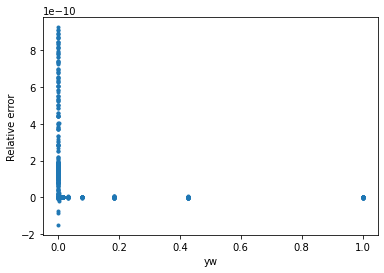

In [36]:
# Set test range
short_vec_yw = np.logspace(np.log10(1e-7), np.log10(1-1e-7), 20) #np.linspace(1e-6, 1-1e-7, 24) # 125
short_vec_T = np.linspace(273.16+5, 1500, 36) # 130
short_vec_rhow = np.linspace(0.1, 1260, 32) # 60
short_vec_ya = np.linspace(1e-7, 1-1e-7, 24)

short_mg_yw, short_mg_T, short_mg_rhow, short_mg_ya = np.meshgrid(
  short_vec_yw, short_vec_T, short_vec_rhow, short_vec_ya, indexing="ij")

short_mg_p_target = np.nan * np.zeros_like(short_mg_yw)
short_mg_vol_energy = np.nan * np.zeros_like(short_mg_yw)
short_mg_rho_mix = np.nan * np.zeros_like(short_mg_yw)

# Iteratively load complete conservative state
for i, j, k, l in np.ndindex(short_mg_yw.shape):
  if short_mg_ya[i,j,k,l] + short_mg_yw[i,j,k,l] <= 1.0:
    (short_mg_vol_energy[i,j,k,l],
     short_mg_rho_mix[i,j,k,l],
     short_mg_p_target[i,j,k,l]) = prim_to_cons(
      short_mg_yw[i,j,k,l],
      short_mg_T[i,j,k,l],
      short_mg_rhow[i,j,k,l],
      short_mg_ya[i,j,k,l])

# Allocate output memory
# mg_p_calc = np.empty_like(mg_yw)
# mg_T_calc = np.empty_like(mg_yw)
valid_indices = np.where((~np.isnan(short_mg_vol_energy.ravel())) & (short_mg_vol_energy.ravel() != 0))
# Simulate vector input
vec_in_vol_energy = short_mg_vol_energy.ravel()[valid_indices]
vec_in_rho_mix = short_mg_rho_mix.ravel()[valid_indices]
vec_in_yw = short_mg_yw.ravel()[valid_indices]
vec_in_ya = short_mg_ya.ravel()[valid_indices]

vec_in_vol_energy0 = vec_in_vol_energy.copy()
_out = float_mix_functions.vec_conservative_to_pT_WLMA(vec_in_vol_energy, vec_in_rho_mix, vec_in_yw, vec_in_ya, K, p_m0, rho_m0,
  c_v_m0, R_a, gamma_a, logger=False)

# Compute relative errors of vectorized wrapper
_vec_rels = _out[1::4] / short_mg_p_target.ravel()[valid_indices] - 1.0
plt.plot(short_mg_yw.ravel()[valid_indices], _vec_rels, '.')
plt.xlabel("yw")
plt.ylabel("Relative error in pressure")

Timing for computing through the vectorizing interface

In [45]:
''' Timing '''
import timeit
N_runs = 2
timing = timeit.timeit(lambda: float_mix_functions.vec_conservative_to_pT_WLMA(
  vec_in_vol_energy, vec_in_rho_mix, vec_in_yw, vec_in_ya,
  K, p_m0, rho_m0, c_v_m0, R_a, gamma_a, logger=False), number=N_runs)
wall_per_input_ms = timing / (N_runs * vec_in_vol_energy.size) * 1e3
print(f"Timing: {wall_per_input_ms} ms average per input")

Timing: 0.1300571905200146 ms average per input


#### Hit count testing

In [34]:
""" Get hit counts from logs """
hit_counts = [0] * (8+1)
for i in range(len(_logger.all_logs)):
  if _logger.all_logs[i]:
    hit_counts[_logger.all_logs[i][0][1].get("alphaw_argmin", -1)] += 1

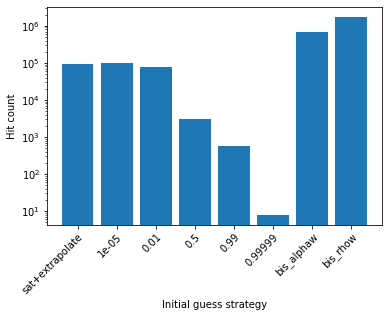

In [76]:
# Plot hit count histogram
fig, ax = plt.subplots()
# Create bar
ax.bar(list(range(8)), hit_counts[:-1], log=True)
ax.set_xlabel("Initial guess strategy")
ax.set_ylabel("Hit count")
# Define labels
labels = ["sat+extrapolate", 1e-5, 0.01, 0.5, 0.99, 1.0-1e-5, "bis_alphaw", "bis_rhow"]

# Label bars on x-axis
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
# Rotate labels
_ = plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

#### Num steps logged testing

In [48]:
""" Get log count from logs as proxy for function call count """
log_counts = [len(log) for log in _logger.all_logs]

Text(0.5, 0, 'Number of steps logged')

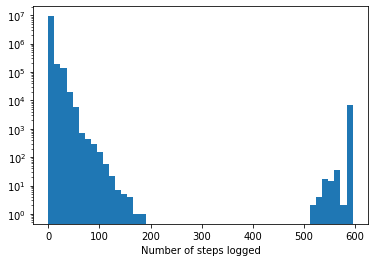

In [60]:
plt.hist(log_counts, log=True, bins=50)
plt.xlabel("Number of steps logged")

In [52]:
""" Pull one log """
# _logger.all_logs[83642]

' Pull one log '

In [53]:
# Save log 
# # import pickle
# with open('log0.pkl', 'wb') as handle:
#   pickle.dump(_logger, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Plot errors

For calibration:
* Note that for T above 1720 K ~ 1760 K: weird things happen
* T too close to triple point is also dangerous

C:\Users\Fredric\AppData\Local\Temp\ipykernel_9360\2014913622.py:3: RuntimeWarning: invalid value encountered in true_divide
  p_reldiffs = np.abs(mg_p_calc / mg_p_target - 1.0)


Text(0.5, 0, '')

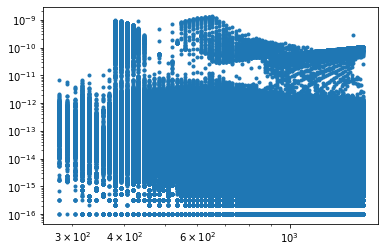

In [6]:
%matplotlib inline
p_diffs = np.abs(mg_p_calc - mg_p_target)
p_reldiffs = np.abs(mg_p_calc / mg_p_target - 1.0)
# plt.loglog((1 - mg_yw - mg_ya)[np.where(~np.isnan(p_reldiffs))], 1e-16+p_reldiffs[np.where(~np.isnan(p_reldiffs))], '.')
# Transform to liquid volfrac
mg_alpham = mg_rho_mix * (1 - mg_yw - mg_ya) / (rho_m0 * (1.0 + (mg_p_target - p_m0) / K))
# plt.loglog(mg_alpham[np.where(~np.isnan(p_reldiffs))], 1e-16+p_reldiffs[np.where(~np.isnan(p_reldiffs))], '.')
plt.loglog(mg_T[np.where(~np.isnan(p_reldiffs))], 1e-16+p_reldiffs[np.where(~np.isnan(p_reldiffs))], '.')
plt.xlabel("")

### Trash below

In [9]:
''' Inspect worst case '''
_ind = np.nanargmax(p_reldiffs.ravel())

# Adjust input, solution to the worst case
''' Inspect worst case '''
_ind = np.nanargmax(p_reldiffs.ravel())
input = {
  "vol_energy": mg_vol_energy.ravel()[_ind],
  "rho_mix": mg_rho_mix.ravel()[_ind],
  "ya" : mg_ya.ravel()[_ind],
  "yw": mg_yw.ravel()[_ind],
}
solution = {
  "p": mg_p_target.ravel()[_ind],
  "rhow": mg_rhow.ravel()[_ind],
  "T": mg_T.ravel()[_ind],
  "x": 0,
}
solution["alphaw"] = input["rho_mix"] * input["yw"] / solution["rhow"]
if solution["p"] == float_mix_functions.prho_sat(solution["T"])["psat"]:
  _out = float_mix_functions.prho_sat(solution["T"])
  rho_satl, rho_satv = _out["rho_satl"], _out["rho_satv"]
  solution["x"] = (1/solution["rhow"] - 1/rho_satl) / (1/rho_satv - 1/rho_satl)

vol_energy = mg_vol_energy.ravel()[_ind]
rho_mix = mg_rho_mix.ravel()[_ind]
yw = mg_yw.ravel()[_ind]
ya = mg_ya.ravel()[_ind]

_logger_loc = SimpleLogger()
_rhopT = float_mix_functions.conservative_to_pT_WLMA_bn(
    vol_energy, rho_mix, yw, ya,
    K, p_m0, rho_m0, c_v_m0,
    R_a, gamma_a, logger=_logger_loc)
input, solution, _logger_loc.curr_log

({'vol_energy': 35542855.57138237,
  'rho_mix': 26.906379095009658,
  'ya': 1e-07,
  'yw': 0.9999999},
 {'p': 1488799.278689497,
  'rhow': 26.906382978723407,
  'T': 471.0821052631579,
  'x': 0.27382884527849866,
  'alphaw': 0.9999997556582888},
 [('info',
   {'stage': 'initialguess',
    'alphaw_candidates': [0.42032455380658273,
     1e-05,
     0.01,
     0.5,
     0.99,
     0.99999,
     0.9999847412124634,
     1.0000431694870773],
    'alphaw_candidate_performance': [1.1700070312072375,
     1.0588660973014465,
     1.0389860972054756,
     1.1567080856416223,
     1.1102974463420292,
     1.1123521415000563,
     1.1123510184379801,
     1.1123634987885482],
    'alphaw_argmin': 2,
    'T_init': 592.5852257304362}),
  ('info',
   {'stage': 'init',
    'f0': -0.2426645783891126,
    'f1': -0.9899999997983383,
    'U0': 0.01,
    'U1': 592.5852257304362,
    'step0': 0.9899997614431277,
    'step1': 4749.681345303679,
    'region_type_curr': 0}),
  ('info',
   {'stage': 'bounds',

In [7]:
np.linalg.svd(_out_debug[1])

NameError: name '_out_debug' is not defined

In [ ]:
_out_debug = float_mix_functions.kernel2_WLMA_debug(
    solution["alphaw"], solution["T"],
    input["vol_energy"], input["rho_mix"], input["yw"], input["ya"],
    K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)

kern = lambda U: float_mix_functions.kernel2_WLMA_debug(U[0], U[1],
    input["vol_energy"], input["rho_mix"], input["yw"], input["ya"],
    K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)
J_fd = np.empty((2,2))
dz = 1e-7
U_center = np.array([solution["alphaw"], solution["T"]])
J_fd[0,0] = (kern(U_center + [dz/2, 0])[0][0] - kern(U_center + [-dz/2, 0])[0][0]) / dz
J_fd[0,1] = (kern(U_center + [0, dz/2])[0][0] - kern(U_center + [0, -dz/2])[0][0]) / dz
J_fd[1,0] = (kern(U_center + [dz/2, 0])[0][1] - kern(U_center + [-dz/2, 0])[0][1]) / dz
J_fd[1,1] = (kern(U_center + [0, dz/2])[0][1] - kern(U_center + [0, -dz/2])[0][1]) / dz
J_fd, _out_debug, np.linalg.solve(_out_debug, _out_debug[0])

c:\Python39\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

Text(0, 0.5, 'T (K)')

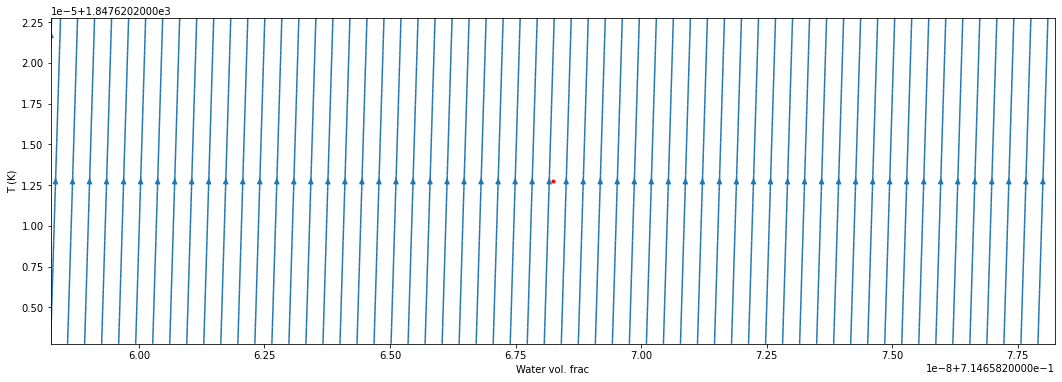

In [ ]:
''' Plot basin of attraction '''

_alpha_range = [solution["alphaw"]-1e-8, solution["alphaw"]+1e-8]
_T_range = [solution["T"]-1e-5, solution["T"]+1e-5]

_alpha_range = np.clip(_alpha_range, 1e-7, 1)
_T_range = np.clip(_T_range, 273.16, 2273.15)
T_basin_vec = np.linspace(*_T_range, 101)
alpha_basin_vec = np.linspace(*_alpha_range, 100)
mg_alpha_basin, mg_T_basin = np.meshgrid(alpha_basin_vec, T_basin_vec)
mg_f = np.zeros((*mg_alpha_basin.shape, 2))
mg_J = np.zeros((*mg_alpha_basin.shape, 2, 2))
mg_J_fd = np.zeros((*mg_alpha_basin.shape, 2, 2))

mg_df = np.zeros((*mg_alpha_basin.shape, 2))
mg_df_future = np.zeros((*mg_alpha_basin.shape, 2))
mg_flags = np.zeros((*mg_alpha_basin.shape,))
mg_U = np.zeros((*mg_alpha_basin.shape, 2))

for i, j in np.ndindex(mg_T_basin.shape):
  # E, V conditions w.r.t. [alpha_w, T]
  mg_f[i,j,:], mg_J[i,j,...], _, _, mg_flags[i,j] = float_mix_functions.kernel2_WLMA_debug(
    mg_alpha_basin[i,j], mg_T_basin[i,j],
    input["vol_energy"], input["rho_mix"], input["yw"], input["ya"],
    K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)
  mg_df[i,j,:] = (-np.linalg.solve(mg_J[i,j,...], mg_f[i,j,:]))
  mg_U[i,j,:] = [mg_alpha_basin[i,j], mg_T_basin[i,j]]
  # # Finite difference J_fd
  # dz = 1e-9
  # J_fd = np.empty((2,2))
  # U_center = np.array([mg_alpha_basin[i,j], mg_T_basin[i,j]])
  # J_fd[0,0] = (kern(U_center + [dz/2, 0])[0][0] - kern(U_center + [-dz/2, 0])[0][0]) / dz
  # J_fd[0,1] = (kern(U_center + [0, dz/2])[0][0] - kern(U_center + [0, -dz/2])[0][0]) / dz
  # J_fd[1,0] = (kern(U_center + [dz/2, 0])[0][1] - kern(U_center + [-dz/2, 0])[0][1]) / dz
  # J_fd[1,1] = (kern(U_center + [0, dz/2])[0][1] - kern(U_center + [0, -dz/2])[0][1]) / dz
  # mg_J_fd[i,j,...] = J_fd

  # Compute df at the next step
  _f, _J, _, _, _ = float_mix_functions.kernel2_WLMA_debug(
    mg_alpha_basin[i,j] + mg_df[i,j,0], mg_T_basin[i,j] + mg_df[i,j,1],
    input["vol_energy"], input["rho_mix"], input["yw"], input["ya"],
    K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)
  mg_df_future[i,j,:] = -np.linalg.solve(mg_J[i,j,...], 0.5 * (_f + mg_f[i,j,:]))

plt.figure(figsize=(18,6))
# plt.subplot(1,3,1)
plt.streamplot(mg_alpha_basin, mg_T_basin, mg_df[...,0], mg_df[...,1], density=2)
plt.plot(solution["alphaw"], solution["T"], '.r')
plt.xlim(mg_alpha_basin.min(), mg_alpha_basin.max())
plt.ylim(mg_T_basin.min(), mg_T_basin.max())

# for _U in seq_list:
  # plt.plot(*_U, '*k')

plt.xlabel("Water vol. frac")
plt.ylabel("T (K)")

# plt.subplot(1,3,2)
# plt.contourf(mg_alpha_basin, mg_T_basin, np.linalg.norm(mg_df/mg_U, axis=-1), levels=100)
# plt.colorbar()
# plt.contour(mg_alpha_basin, mg_T_basin, np.linalg.norm(mg_df/mg_U, axis=-1), levels=[1.0], colors=["red"])
# plt.plot(solution["alphaw"], solution["T"], '.r')
# plt.xlabel("Water vol. frac")
# plt.ylabel("T (K)")
# plt.title("Relative step size")

# plt.subplot(1,3,3)
# plt.contourf(mg_alpha_basin, mg_T_basin, mg_flags, density=2)
# plt.colorbar()
# plt.plot(solution["alphaw"], solution["T"], '.r')
# plt.xlabel("Water vol. frac")
# plt.ylabel("T (K)")

# plt.figure(figsize=(18,6))
# plt.subplot(1,3,1)
# plt.streamplot(mg_alpha_basin, mg_T_basin, mg_df_future[...,0], mg_df_future[...,1], density=2)
# plt.plot(solution["alphaw"], solution["T"], '.r')
# plt.xlabel("Water vol. frac")
# plt.ylabel("T (K)")